### Sequential Training and Evaluation for Lane Detection Model

In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch.optim import Adam
import torch.nn.functional as F
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, performance_report
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Device :", device )

Available Device : cpu


### Dataset Class

This cell defines the `LaneDataset` class to handle the TUSimple lane detection dataset:

1. **Initialization (`__init__`)**:
   - Loads the dataset based on mode (`train` or `test`).
   - Sets image size and paths for preprocessing.

2. **Data Loading (`__getitem__`)**:
   - Reads and preprocesses images and segmentation labels.
   - Converts data to tensors and prepares output as a dictionary.

3. **Visualization (`_show_sample_dataset`)**:
   - Displays sample images and segmentation labels for verification.

4. **Length (`__len__`)**:
   - Returns the number of samples in the dataset.

This class prepares the dataset for training and testing. Test it by creating an instance and visualizing samples.

In [4]:
PATH = './dataset/TUSimple'

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path= PATH, train=True, size=(800, 360)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "test"
        self._image_size = size # w, h
        self._data = []

        if self._mode == "train":
            file_path = "train_val_gt.txt"
        elif self._mode == "test":
            file_path = "test_gt.txt"
        self._process_list(os.path.join(self._dataset_path, "train_set/seg_label/list", file_path))
            
    def __getitem__(self, idx):
        img_path = self._dataset_path + ("/train_set" if self._mode == "train" else "/test_set") + self._data[idx][0]
        image = cv2.imread(img_path)
        h, w, c = image.shape
        raw_image = image
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ins_segmentation_path = self._dataset_path + "/train_set" + self._data[idx][1]
        ins_segmentation_image = cv2.imread(ins_segmentation_path)
        ins_segmentation_image = ins_segmentation_image[:, :, 0]
        ins_segmentation_image = cv2.resize(ins_segmentation_image, self._image_size, interpolation=cv2.INTER_LINEAR)
        
        segmentation_image = ins_segmentation_image.copy()
        segmentation_image[segmentation_image > 0] = 1
        
        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy()).to(torch.int64)
        ins_segmentation_image =  torch.from_numpy(ins_segmentation_image.copy())
        
        exists = [int(i) for i in self._data[idx][2]]
        exists = torch.as_tensor(exists)
        
        output = {
            'img_path' : img_path,
            'img' : image,
            "meta" : { "full_img_path" : img_path ,
                     "img_name" :  self._data[ idx ][ 0 ]},
            'segLabel' : segmentation_image,
            'IsegLabel' : ins_segmentation_image,
            'exist' : exists,
            "original_image" : raw_image,
            "label" : segmentation_image
        }
        
        return output
    
    def probmap2lane(self, seg_pred, exist, resize_shape=(720, 1280), smooth=True, y_px_gap=10, pts=56, thresh=0.6):
        """
        Arguments:
        ----------
        seg_pred:      np.array size (5, h, w)
        resize_shape:  reshape size target, (H, W)
        exist:       list of existence, e.g. [0, 1, 1, 0]
        smooth:      whether to smooth the probability or not
        y_px_gap:    y pixel gap for sampling
        pts:     how many points for one lane
        thresh:  probability threshold
    
        Return:
        ----------
        coordinates: [x, y] list of lanes, e.g.: [ [[9, 569], [50, 549]] ,[[630, 569], [647, 549]] ]
        """
        if resize_shape is None:
            resize_shape = seg_pred.shape[1:]  # seg_pred (5, h, w)
        _, h, w = seg_pred.shape
        H, W = resize_shape
        coordinates = []
    
        for i in range(self.cfg.num_classes - 1):
            prob_map = seg_pred[i + 1]
            if smooth:
                prob_map = cv2.blur(prob_map, (9, 9), borderType=cv2.BORDER_REPLICATE)
            coords = self.get_lane(prob_map, y_px_gap, pts, thresh, resize_shape)
            if self.is_short(coords):
                continue
            coordinates.append(
                [[coords[j], H - 10 - j * y_px_gap] if coords[j] > 0 else [-1, H - 10 - j * y_px_gap] for j in
                 range(pts)])
    
    
        if len(coordinates) == 0:
            coords = np.zeros(pts)
            coordinates.append(
                [[coords[j], H - 10 - j * y_px_gap] if coords[j] > 0 else [-1, H - 10 - j * y_px_gap] for j in
                 range(pts)])
        #print(coordinates)
    
        return coordinates
    
    def _process_list(self, file_path):
        with open(file_path) as f:
            for line in f:
                words = line.split()
                image = words[0]
                segmentation = words[1]
                exists = words[2:]
                self._data.append((image, segmentation, exists)) 
                
    def _show_sample_dataset( self, number_samples = 10 ):
        
        # Visualizing some Lane Detection dataset
    
        sns.set_theme()

        f, axarr = plt.subplots( number_samples   ,3 , figsize = ( 20 , 30 ))
        
        plt.axis('off')

        for i in range( number_samples ):

            axarr[ i , 0].imshow(  self.__getitem__( idx = i )[ "original_image" ]  )
            axarr[ i , 0 ].set_title( "Lane Image Data No " + str( i + 1) )
            axarr[ i , 0 ].set_axis_off()
            
            axarr[ i , 1 ].imshow(  self.__getitem__( idx = i )[ "segLabel" ] )
            axarr[ i , 1 ].set_title( "Lane Image Segmentation Data No " + str( i + 1) )
            axarr[ i , 1 ].set_axis_off()
            
            axarr[ i , 2 ].imshow(  self.__getitem__( idx = i )[ "IsegLabel" ] )
            axarr[ i , 2 ].set_title( "Lane Image Segmentation Data No " + str( i + 1) )
            axarr[ i , 2 ].set_axis_off()

        f.tight_layout()
        plt.show()
                
    def __len__(self):
        return len(self._data)  

### Image Loading Test


1. **Input**:
   - The `image_path` specifies the path to the image file.

2. **Loading**:
   - Uses OpenCV (`cv2.imread`) to load the image.

3. **Validation**:
   - Checks if the image is loaded properly.
   - Prints a success message if the image is loaded.
   - Displays an error message if the image cannot be loaded (e.g., file corrupted or unsupported format).

quick check to ensure the dataset is accessible and the file paths are correctly set.

In [5]:
import cv2

image_path = './dataset/TUSimple/train_set/clips/0313-1/6040/20.jpg'
image = cv2.imread(image_path)
if image is None:
    print("ERROR: Unable to load image. File may be corrupted or unsupported format.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


### Dataset Creation and Visualization

1. **Dataset Creation**:
   - The `LaneDataset` object is instantiated with a specified image size of `(880, 368)`.
   - This initializes the dataset for training or testing purposes, depending on the `train` parameter in the class.

2. **Visualization**:
   - The `_show_sample_dataset()` method is called with `number_samples=10`.
   - Displays 10 random samples from the dataset.
     - First column: Original lane images.
     - Second column: Segmentation labels.
     - Third column: Instance segmentation labels.

3. **Purpose**:
   - Confirms that the dataset has been properly loaded and processed.
   - Allows for visual inspection of the dataset to ensure it aligns with the task objectives.

crucial for verifying data integrity and understanding the dataset's structure before training a model.

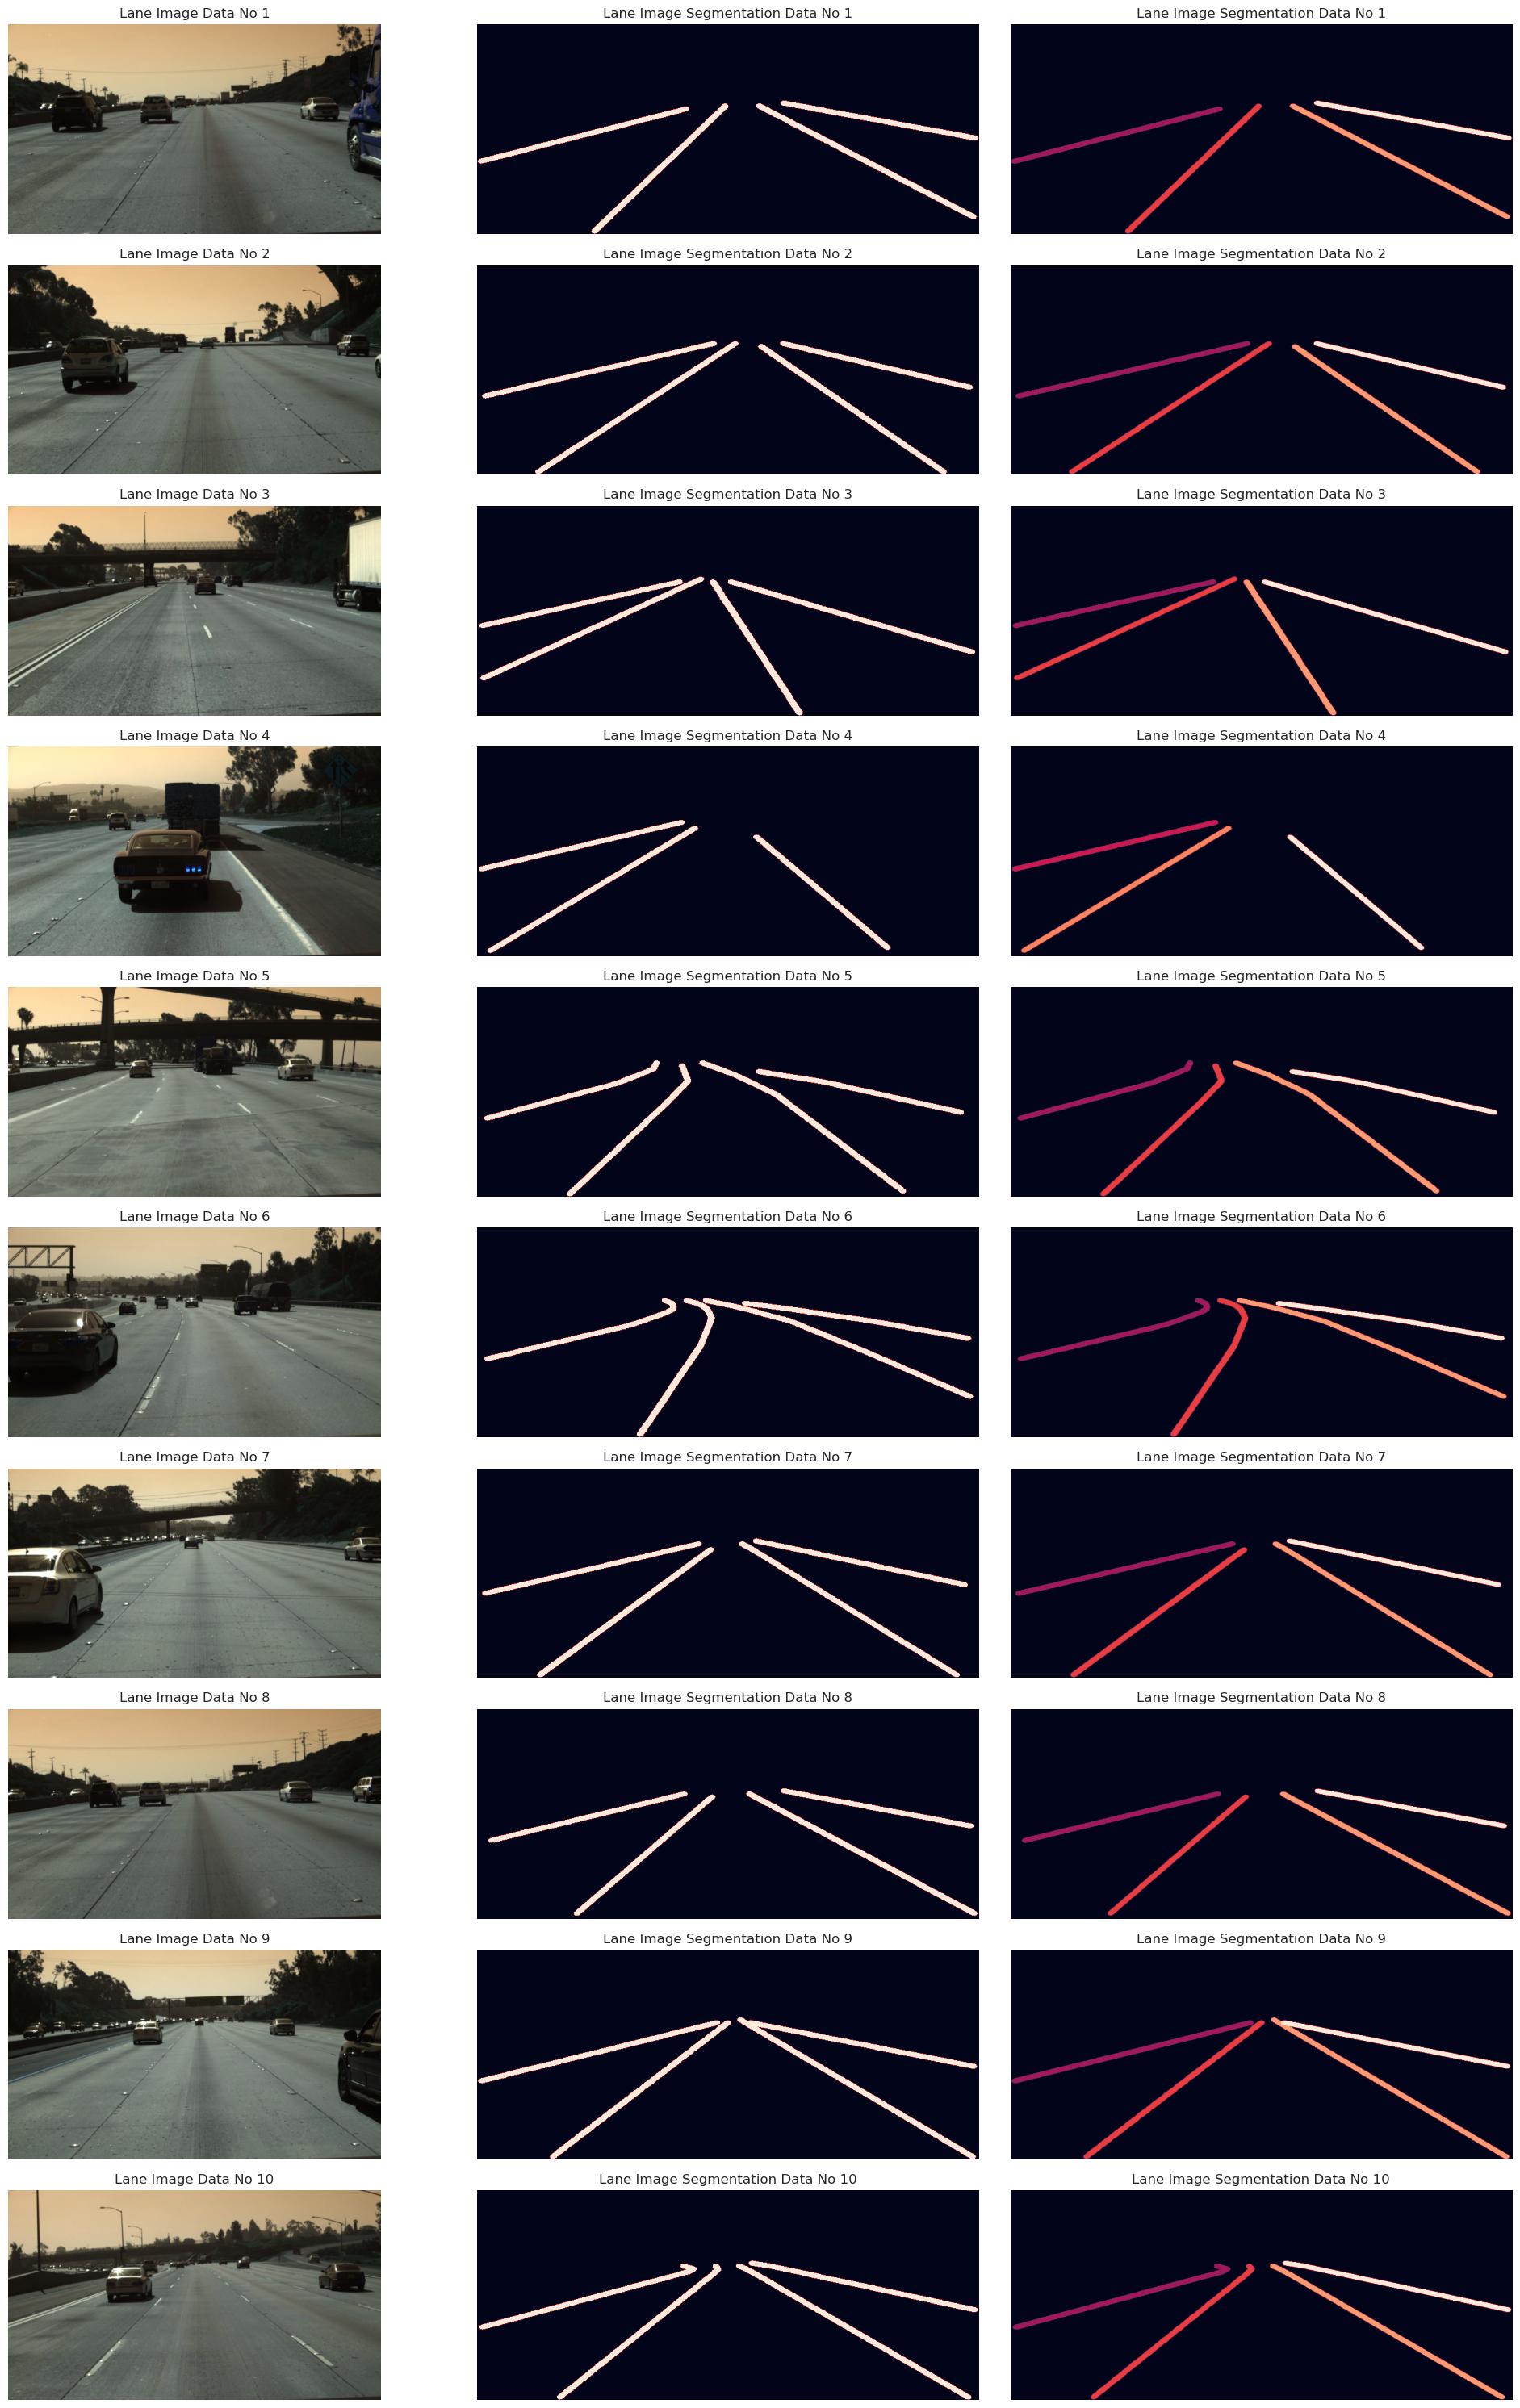

In [6]:

# Create the dataset
dataset = LaneDataset(size=(880, 368))

# Visualize samples
dataset._show_sample_dataset( number_samples= 10 )

### Model Definition and Loss Functions

1. **Coordinate Attention Mechanism**:
   - A `CoordAttention` class enhances the spatial and channel attention of the model.
   - Features:
     - Uses horizontal and vertical pooling to capture cross-dimensional relationships.
     - Reduces dimensionality using a convolutional layer, processes separately, and then combines them.
     - Helps the model focus on relevant regions in the image while preserving input features.

2. **Lane Detection Model**:
   - Built using ResNet-50 as a backbone.
   - Encoder:
     - Uses the pre-trained ResNet-50 (excluding fully connected layers).
   - Coordinate Attention:
     - Integrated after encoding for better focus on spatial details.
   - Decoder:
     - U-Net-like structure with transposed convolutions for upsampling.
     - Outputs a segmentation mask with the specified number of classes.

3. **Dice Loss**:
   - Measures overlap between predicted and ground truth masks.
   - Returns a value between 0 and 1, with 0 indicating perfect overlap.
   - Suitable for binary segmentation tasks.

4. **IoU Loss**:
   - Computes the Intersection over Union (IoU) between predicted and ground truth masks.
   - Penalizes incorrect segmentation more effectively in multi-class or overlapping regions.

5. **Purpose**:
   - The attention mechanism and decoder structure make the model robust for lane segmentation.
   - Loss functions (DiceLoss and IoULoss) are optimized for pixel-level segmentation tasks, ensuring accurate results.

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class CoordAttention(nn.Module):
    """
    Coordinate Attention Mechanism to enhance spatial and channel focus.
    """
    def __init__(self, in_channels, out_channels, reduction=32):
        super(CoordAttention, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))  # Horizontal pooling (height remains, width = 1)
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))  # Vertical pooling (width remains, height = 1)

        mid_channels = max(8, in_channels // reduction)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        self.conv_h = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        self.conv_w = nn.Conv2d(mid_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x  # Save the input for later addition
        n, c, h, w = x.size()

        # Perform horizontal and vertical pooling
        x_h = self.pool_h(x)  # Shape: (n, c, h, 1)
        x_w = self.pool_w(x)  # Shape: (n, c, 1, w)

        # Pass pooled features through conv1
        x_h = self.conv1(x_h)  # Shape: (n, mid_channels, h, 1)
        x_w = self.conv1(x_w)  # Shape: (n, mid_channels, 1, w)

        # Broadcast to match spatial dimensions
        x_h = x_h.expand(-1, -1, h, w)  # Expand width to match input (n, mid_channels, h, w)
        x_w = x_w.expand(-1, -1, h, w)  # Expand height to match input (n, mid_channels, h, w)

        # Combine horizontally and vertically processed features
        combined = x_h + x_w  # Shape: (n, mid_channels, h, w)

        # Pass through relu and final conv layers
        combined = self.relu(combined)
        x_h = self.conv_h(combined)  # Shape: (n, out_channels, h, w)
        x_w = self.conv_w(combined)  # Shape: (n, out_channels, h, w)

        return torch.sigmoid(x_h + x_w) * identity  # Combine with input features


class LaneDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(LaneDetectionModel, self).__init__()
        # ResNet-50 backbone
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC layers

        # Coordinate Attention
        self.coord_att = CoordAttention(2048, 2048)

        # Upsampling head (U-Net-like)
        self.up1 = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        )
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)  # Output segmentation mask

    def forward(self, x):
        # Encoder
        features = self.encoder(x)

        # Coordinate Attention
        features = self.coord_att(features)

        # Decoder
        x = self.up1(features)
        x = self.up2(x)
        x = self.up3(x)

        # Final segmentation output
        x = self.final_conv(x)
        return x


In [8]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Apply sigmoid for binary masks
        intersection = (pred * target).sum(dim=(2, 3))
        dice_score = 2.0 * intersection / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)))
        return 1 - dice_score.mean()


In [9]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Convert logits to probabilities
        intersection = (pred * target).sum(dim=(2, 3))
        union = (pred + target - pred * target).sum(dim=(2, 3))
        iou = intersection / union
        return 1 - iou.mean()




#### **Training Function**
The `train` function performs a single epoch of training for the model. It calculates the loss and updates the model weights using the optimizer. Additionally, it calculates the accuracy for each batch and updates the progress bar with the loss and accuracy.

Key steps:
1. **Model Training Mode**: Sets the model to training mode using `model.train()`.
2. **Batch Processing**:
   - Moves `images` and `targets` to the specified device (CPU/GPU).
   - Performs forward pass and calculates the loss using the specified criterion.
   - Computes gradients via `loss.backward()` and updates model weights using `optimizer.step()`.
3. **Accuracy Calculation**: Compares predicted classes to ground truth to calculate batch accuracy.
4. **Progress Bar Updates**: Displays batch loss and accuracy.

**Returns**: 
- Average loss for the epoch.
- Average accuracy for the epoch.

---

#### **Validation Function**
The `validate` function evaluates the model on the validation set without updating its weights. It calculates the loss and accuracy for each batch and updates the progress bar.

Key steps:
1. **Model Evaluation Mode**: Sets the model to evaluation mode using `model.eval()` and disables gradient computation with `torch.no_grad()`.
2. **Batch Processing**:
   - Moves `images` and `targets` to the specified device (CPU/GPU).
   - Performs forward pass and calculates the loss using the specified criterion.
3. **Accuracy Calculation**: Similar to the training function, but without gradient updates.
4. **Progress Bar Updates**: Displays batch loss and accuracy.

**Returns**: 
- Average loss for the validation set.
- Average accuracy for the validation set.



In [10]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Training Function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_accuracy = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        # Load data
        images = batch['img'].to(device)
        targets = batch['segLabel'].to(device)

        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=targets.shape[1:], mode='bilinear', align_corners=False)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted_classes = torch.argmax(outputs, dim=1)
        correct = (predicted_classes == targets).float().sum()
        total = targets.numel()
        accuracy = correct / total

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        # Update progress bar
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Accuracy": f"{accuracy.item() * 100:.2f}%"})

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    return avg_loss, avg_accuracy

# Validation Function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    progress_bar = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            # Load data
            images = batch['img'].to(device)
            targets = batch['segLabel'].to(device)

            # Forward pass
            outputs = model(images)
            outputs = F.interpolate(outputs, size=targets.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, targets)

            # Calculate accuracy
            predicted_classes = torch.argmax(outputs, dim=1)
            correct = (predicted_classes == targets).float().sum()
            total = targets.numel()
            accuracy = correct / total

            total_loss += loss.item()
            total_accuracy += accuracy.item()

            # Update progress bar
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Accuracy": f"{accuracy.item() * 100:.2f}%"})

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)

    return avg_loss, avg_accuracy



#### **Train with Checkpoints**

The `train_with_checkpoints` function combines training, validation, and model checkpointing for a complete training pipeline. It also records system metrics such as CPU and memory usage for better monitoring.

---

### Key Steps:
1. **Directory Management**:
   - Ensures that the checkpoint directory exists using `os.makedirs(checkpoint_dir, exist_ok=True)`.

2. **Epoch Loop**:
   - For each epoch:
     - **Training and Validation**: Calls the `train` and `validate` functions, capturing loss and accuracy.
     - **Timing**: Measures time taken for each epoch using `time.time()`.
     - **System Monitoring**: Uses the `psutil` library to get CPU and memory usage metrics.
   - Prints all key metrics: training loss, training accuracy, validation loss, validation accuracy, time taken, CPU usage, and memory usage.

3. **Checkpoint Saving**:
   - **Best Checkpoint**: Saves the model if the validation loss improves using `torch.save`. The filename includes the model name, epoch, and validation loss.
   - **Current Checkpoint**: Saves the model state for the current epoch, regardless of validation loss improvement.

4. **Checkpoint Contents**:
   - Each checkpoint includes:
     - Current epoch
     - `model.state_dict()` (model parameters)
     - `optimizer.state_dict()` (optimizer state)
     - Validation loss or best loss.

---

### Features:
1. **System Monitoring**:
   - Displays CPU usage and memory utilization, helpful for debugging performance bottlenecks.

2. **Model Checkpointing**:
   - Tracks both the best model and the current epoch's model for safety and progress tracking.

3. **Readability**:
   - Uses a clear and consistent structure to log metrics and model states.

4. **Ease of Resumption**:
   - Saved checkpoints enable restarting training from any epoch without losing progress.


In [11]:
import os
import time
import torch
import psutil
from tqdm import tqdm

def train_with_checkpoints(
    model, train_loader, val_loader, optimizer, criterion, device, epochs, checkpoint_dir="checkpoints", model_name="resnet50"
):
    best_val_loss = float("inf")

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 30)

        # Record start time
        start_time = time.time()

        # Train and Validate
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Record end time
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Get CPU and memory usage
        cpu_usage = psutil.cpu_percent(interval=None)
        memory_info = psutil.virtual_memory()

        # Print Metrics and System Info
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")
        print(f"Time Taken: {elapsed_time:.2f} seconds")
        print(f"CPU Usage: {cpu_usage}%")
        print(f"Memory Usage: {memory_info.percent}%")

        # Checkpoint naming
        checkpoint_name = f"{model_name}_epoch{epoch + 1}_valLoss{val_loss:.4f}.pth"
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

        # Save Checkpoint if Validation Loss Improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            }, checkpoint_path)
            print(f"Best model checkpoint saved at {checkpoint_path}")

        # Save current epoch checkpoint
        current_checkpoint_name = f"{model_name}_current_epoch{epoch + 1}.pth"
        current_checkpoint_path = os.path.join(checkpoint_dir, current_checkpoint_name)
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": val_loss,
        }, current_checkpoint_path)
        print(f"Current model checkpoint saved at {current_checkpoint_path}")
    
    print("\nTraining Complete!")


### Model, Optimizer, and Criterion
- **Model:** The `LaneDetectionModel` is initialized for binary classification (`num_classes=2`) and moved to the appropriate computation device (`device`).
- **Optimizer:** `AdamW` is used for efficient training with weight decay (`1e-4`) to prevent overfitting.
- **Loss Function:** `CrossEntropyLoss` is suitable for comparing the predicted logits with the true target labels.

### Dataset and Data Loaders
- **Training and Validation Datasets:**
  - `LaneDataset` is used to load training (`train_dataset`) and validation (`val_dataset`) data.
  - Images are resized to a resolution of `800x360`.

- **Data Loaders:**
  - `train_loader` batches the training data with `batch_size=8` and shuffles it for better generalization.
  - `val_loader` batches the validation data with `batch_size=8` without shuffling to maintain consistency.


In [12]:
# Model, optimizer, and criterion
model = LaneDetectionModel(num_classes=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Assuming LaneDataset is already defined and loaded
train_dataset = LaneDataset(dataset_path="./dataset/TUSimple", train=True, size=(800, 360))
val_dataset = LaneDataset(dataset_path="./dataset/TUSimple", train=False, size=(800, 360))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


/home/pendem.mu/.conda/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pendem.mu/.conda/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model Architecture Overview

The **`LaneDetectionModel`** is a custom neural network designed for lane detection. Here's a breakdown of its architecture:

#### **1. Encoder**
- **Backbone:** Utilizes a ResNet-50 pretrained model for feature extraction.
- **Layers:** 
  - The encoder is composed of the ResNet-50's convolutional layers (`conv1` to `conv5`), excluding the fully connected (FC) layer.
  - Includes multiple bottleneck layers, each with convolutional, batch normalization, and ReLU activation layers.
  - Downsampling is performed via stride 2 in certain layers, reducing spatial dimensions and capturing hierarchical features.

#### **2. Coordinate Attention Mechanism**
- Enhances the network's spatial and channel focus.
- **Key Components:**
  - **Horizontal and Vertical Pooling:** Pools features along height and width independently.
  - **Convolutions and ReLU:** Combines and refines the pooled features to highlight important regions.
  - **Attention Map:** Multiplies with the input features to apply spatial and channel attention.

#### **3. Decoder**
- A U-Net-inspired architecture to upsample the encoder's feature maps to the original resolution.
- **Upsampling Stages:**
  - **`up1:`** Converts 2048 channels to 512 through upsampling.
  - **`up2:`** Converts 512 channels to 128.
  - **`up3:`** Converts 128 channels to 32.
- **Final Convolution:** Reduces the channels to 2 for segmentation.

#### **4. Bottleneck Details**
- Each bottleneck block contains:
  - Three convolutional layers (`conv1`, `conv2`, `conv3`).
  - Batch normalization after each convolution.
  - A downsampling shortcut when the spatial dimensions need adjustment.

#### **5. Output**
- Produces segmentation maps with two channels (binary classification) indicating lane presence.

---

### Detailed Model Layers
- **Input:** 3-channel RGB image.
- **Intermediate Layers:** Sequential layers from ResNet-50, Coordinate Attention mechanism, and U-Net-like decoder.
- **Output:** Segmentation mask with dimensions matching the input image's spatial size.

---

### Use Cases
- Designed for lane detection in autonomous driving applications.
- Efficient at learning spatial features while refining outputs through attention mechanisms.

---

### Summary Table of Key Components:
| Component                  | Description                                     |
|----------------------------|-------------------------------------------------|
| **Encoder**                | ResNet-50 pretrained backbone                  |
| **Coordinate Attention**   | Enhances spatial and channel focus             |
| **Decoder**                | U-Net-inspired upsampling architecture         |
| **Output**                 | Segmentation map indicating detected lanes     |


In [13]:
model.eval()

LaneDetectionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [14]:
train_with_checkpoints(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device='cpu',
    epochs=5,
    checkpoint_dir="checkpoints-large-model"
)

Epoch 1/5
------------------------------


Train Loss: 0.0726, Train Accuracy: 97.08%
Validation Loss: 0.0527, Validation Accuracy: 97.79%
Time Taken: 1801.61 seconds
CPU Usage: 98.7%
Memory Usage: 5.5%
Best model checkpoint saved at checkpoints-large-model/resnet50_epoch1_valLoss0.0527.pth
Current model checkpoint saved at checkpoints-large-model/resnet50_current_epoch1.pth
Epoch 2/5
------------------------------


Train Loss: 0.0517, Train Accuracy: 97.78%
Validation Loss: 0.0530, Validation Accuracy: 97.70%
Time Taken: 1890.81 seconds
CPU Usage: 99.9%
Memory Usage: 5.5%
Current model checkpoint saved at checkpoints-large-model/resnet50_current_epoch2.pth
Epoch 3/5
------------------------------


Train Loss: 0.0477, Train Accuracy: 97.95%
Validation Loss: 0.0468, Validation Accuracy: 98.06%
Time Taken: 1872.28 seconds
CPU Usage: 99.9%
Memory Usage: 5.5%
Best model checkpoint saved at checkpoints-large-model/resnet50_epoch3_valLoss0.0468.pth
Current model checkpoint saved at checkpoints-large-model/resnet50_current_epoch3.pth
Epoch 4/5
------------------------------


Train Loss: 0.0457, Train Accuracy: 98.03%
Validation Loss: 0.0493, Validation Accuracy: 98.03%
Time Taken: 1869.14 seconds
CPU Usage: 99.8%
Memory Usage: 5.5%
Current model checkpoint saved at checkpoints-large-model/resnet50_current_epoch4.pth
Epoch 5/5
------------------------------


Train Loss: 0.0437, Train Accuracy: 98.11%
Validation Loss: 0.0443, Validation Accuracy: 98.15%
Time Taken: 1858.90 seconds
CPU Usage: 99.9%
Memory Usage: 5.5%
Best model checkpoint saved at checkpoints-large-model/resnet50_epoch5_valLoss0.0443.pth
Current model checkpoint saved at checkpoints-large-model/resnet50_current_epoch5.pth

Training Complete!


### Evaluating the Model and Visualizing Predictions

This cell demonstrates the evaluation of the trained model on a sample from the validation dataset. It includes the following steps:

1. **Model Evaluation**:
   - The model is set to evaluation mode using `model.eval()`.
   - A single sample is fetched from the validation dataset, and the input image (`img`) is passed to the model for prediction.

2. **Prediction**:
   - The model's output is processed by applying `torch.argmax` to obtain the predicted segmentation map.
   - The prediction is converted to a NumPy array for visualization.

3. **Visualization**:
   - The ground truth segmentation label (`segLabel`) and the model's predicted segmentation map (`prediction`) are visualized side by side using `matplotlib`.

4. **Device Specification**:
   - The evaluation is conducted on the CPU for simplicity.

#### Key Outputs:
- **Left Image**: Ground Truth segmentation map from the dataset.
- **Right Image**: Predicted segmentation map generated by the model.

#### Note:
This visualization helps assess the model's ability to detect and segment lanes accurately, offering immediate insight into its performance.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


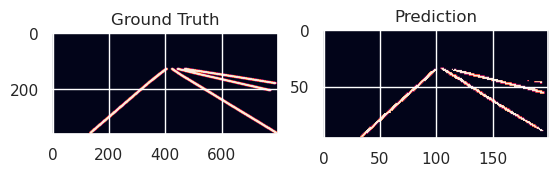

In [15]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataset, device):
    model.eval()
    with torch.no_grad():
        sample = dataset[0]  # Get a sample
        img = sample['img'].to(device).unsqueeze(0)
        seg_label = sample['segLabel'].cpu().numpy()
        
        # Predict segmentation
        prediction = model(img)
        prediction = torch.argmax(prediction, dim=1).cpu().squeeze(0).numpy()
        print(prediction)
        # Visualize results
        plt.subplot(1, 2, 1)
        plt.title("Ground Truth")
        plt.imshow(seg_label)
        plt.subplot(1, 2, 2)
        plt.title("Prediction")
        plt.imshow(prediction)
        plt.show()

evaluate_model(model, val_dataset, "cpu")


In [16]:
def evaluate_model_with_image(model, image_path, device='cpu', image_size=(800, 360)):
    """
    Evaluate the model with an uploaded image.

    Args:
        model: The trained PyTorch model.
        image_path: Path to the uploaded image.
        device: Device to run the model on ('cpu' or 'cuda').
        image_size: Size to resize the image to match model input (width, height).
    """
    model.eval()
    with torch.no_grad():
        # Load and preprocess the image
        raw_image = cv2.imread(image_path)
        raw_image_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(raw_image, image_size, interpolation=cv2.INTER_LINEAR)
        image_tensor = torch.from_numpy(resized_image).float().permute((2, 0, 1)).unsqueeze(0).to(device)

        # Predict segmentation
        prediction = model(image_tensor)
        prediction = torch.argmax(prediction, dim=1).cpu().squeeze(0).numpy()

        # Visualize results
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(raw_image_rgb)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Prediction")
        plt.imshow(prediction, cmap="gray")
        plt.axis("off")

        plt.show()

### Evaluating the Model on a Custom Image

This function allows you to evaluate the trained model on an uploaded image. It provides a visual comparison of the original image and the predicted segmentation. Below are the steps outlined:

#### **Functionality**:
1. **Image Preprocessing**:
   - The image is loaded from the provided `image_path` using OpenCV.
   - It is resized to the required input size for the model (`image_size`) and converted to a tensor format.

2. **Model Prediction**:
   - The trained model is set to evaluation mode with `model.eval()` to disable gradients.
   - The processed image is passed through the model, and the prediction is obtained by applying `torch.argmax` to generate the segmentation map.

3. **Visualization**:
   - The original image is displayed on the left for context.
   - The predicted segmentation map is displayed on the right in grayscale, showing the model's output.

#### **Inputs**:
- `model`: The trained PyTorch model for lane detection.
- `image_path`: Path to the image to evaluate.
- `device`: The device to run inference on (`cpu` or `cuda`).
- `image_size`: Size of the image after resizing (default: `(800, 360)`).

#### **Outputs**:
- A side-by-side visualization:
  - **Left Panel**: Original uploaded image.
  - **Right Panel**: Segmentation prediction output from the model.

#### **Use Case**:
This function is useful for testing the model on unseen or custom images, providing immediate visual feedback on its segmentation performance.

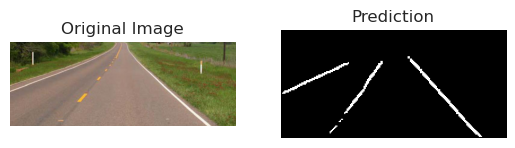

In [17]:
evaluate_model_with_image(model, "./road-4.jpg")  